A notebook to test quickly new features 

In [1]:
import torch
from torch.utils.data import Dataset, DataLoader 
import os 
import numpy as np


0. Creation d'une liste de path vers les données 

In [2]:
folder_path = "../Data/charly/spectrograms_win800_fra200_rFalse_nfft800_nmelsNone_amptodbTrue/"

In [ ]:
#on créé un dataLoader qui charge les données contenu dans folder_path
# mais quand les données ne peuvent pas toutes être chargée en même temps ? comment on fait ? 

In [3]:
#on veut avoir une liste de spectre sous forme de tenseur
#on forme d'abord une liste de tous les paths possibles des fichiers wav
all_wav = []
folders_locuteur = os.listdir(folder_path)
for folder in folders_locuteur:
    wav_files = os.listdir(folder_path + folder)
    for wav in wav_files:
        all_wav.append(folder_path + folder + "/" + wav)
    


In [4]:
#on mélange la liste (à voir en terme de curriculum learning)
np.random.shuffle(all_wav)
print(all_wav[0])

../Data/charly/spectrograms_win800_fra200_rFalse_nfft800_nmelsNone_amptodbTrue/719c2767dd12983694cd8bf3683304acb55473f9acbdb6e88b8f1ba00ee0020889d66718c907214edb71b1cebe0753d120ee64c8f2b2b0b78ab62ca705ea32b6/common_voice_ru_20636438_1.npy


1. Visualisation de quelques spectrogrammes 

In [5]:
#on charge les spectres dans une liste ON NE PEUT PAS TOUS LES CHARGER ENSEMBLE !
spectrograms = []
partial_all_wav = all_wav[:10]
for wav in partial_all_wav:
    spectrograms.append(np.load(wav))
    
    

In [6]:

#on trnaspose les spectres
spectrograms = [np.transpose(spectrogram) for spectrogram in spectrograms]


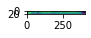

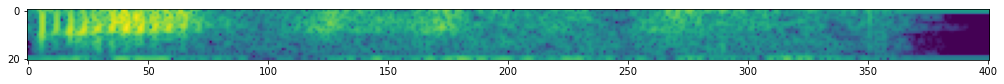

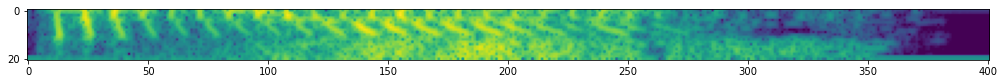

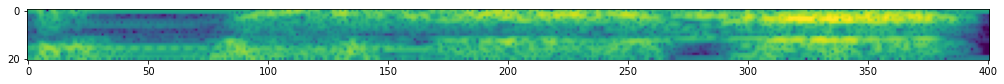

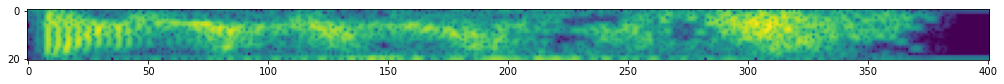

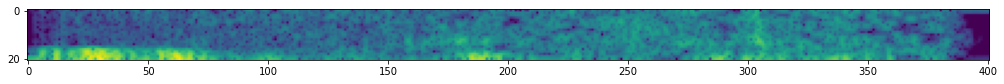

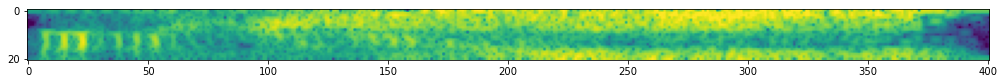

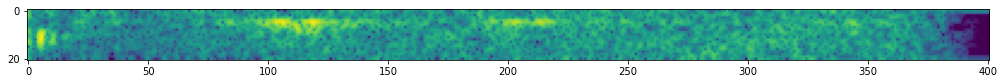

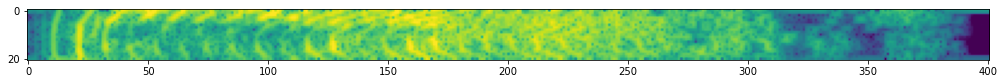

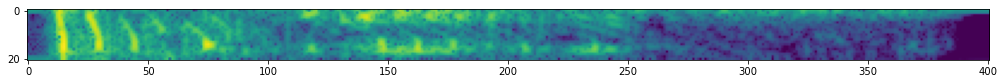

In [7]:
#on visualise 10 spectrogrammes
import matplotlib.pyplot as plt
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(spectrograms[i])
    plt.rcParams['figure.figsize'] = [100, 50]
    plt.show()


2. Creation du DataLoader 

In [10]:
#on prend un sous-ensemble du dataset pour l'instant 
spectro_path = all_wav #[:10000]



In [11]:
#on va faire un dataset qui prend en entrée un path et qui renvoie le spectre correspondant
#la classe children de torch.Dataset permet de faire la transformation des données avant de les chargés dans le DataLoader
#train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)

class SpectroDataset(Dataset):
    """
    A custom dataset to load spectrograms
    """
    def __init__(self, datapath):
        self.path = datapath

# dans le cas où ne peut pas charger toutes les données en RAM en même temps, 
# on charge les données et on les transforme uniquement lors de l'appel de la méthode __getitem__
    def __len__(self):
        return len(self.path)

    def __getitem__(self, idx):
        link = self.path[idx]
        spectro = np.load(link)
        spectro = np.transpose(spectro)
        spectro = torch.from_numpy(spectro)
        return spectro
        #return self.data[idx]

In [12]:
spectros = SpectroDataset(spectro_path) 

In [13]:
#le dataloader doit prendre 
data_loader = DataLoader(spectros,batch_size=16,shuffle=True)

In [14]:
batch = next(iter(data_loader))
print(batch.shape)
'''
contrairement aux images de formes nxHxW là on a que deux dimensions... 
2 solutions (on change l'input demandé ou on change l'input) :
on rajoue artificiellement une dimension ? 
ou on peut s'arranger pour que le forward prennent que 2 dimensions ?
'''

torch.Size([16, 21, 401])


"\ncontrairement aux images de formes nxHxW là on a que deux dimensions... \n2 solutions (on change l'input demandé ou on change l'input) :\non rajoue artificiellement une dimension ? \nou on peut s'arranger pour que le forward prennent que 2 dimensions ?\n"

3. Reproduction avec modele de Charly

In [ ]:
'''
class VAECharly(nn.Module):

    def __init__(self, encoder, bottleneck,
        reconstructor, beta, metric_name='mse', init=None):

        # revoir le pourquoi du comment on fait ça (ça initialise les paramètres de la classe parent non ?)
        super(VAECharly, self).__init__()

        self.encoder = construct_from_kwargs(encoder)
        self.bottleneck = construct_from_kwargs(bottleneck)
        self.reconstructor = construct_from_kwargs(reconstructor)
        self.metric_name = metric_name
        self.beta = beta

        self.apply(kaiming_uniform_init)
        # if init is not None:
        #     if init == 'kaiming_uniform':
        #         self.apply(kaiming_uniform_init)
        #     elif init == 'kaiming_normal':
        #         self.apply(kaiming_normal_init)
        #     elif init == 'xavier_normal':
        #         self.apply(xavier_normal_init)
        #     elif init == 'xavier_uniform':
        #         self.apply(xavier_uniform_init)


    # @property
    # def metric_names(self):
    #     metrics = ['loss', 'mse', 'total_kld', 'mean_kld']
    #     return metrics

    # @property
    # def early_stopping_metric_name(self):
    #     return self.metric_name

    def forward(self, x):
        distributions = self.encoder(x)
        bottleneck_results = self.bottleneck(distributions)
        logits = self.reconstructor(bottleneck_results['z'])
        bottleneck_results.update({'logits': logits})
        return bottleneck_results

    def loss(self, forward_data, targets):
        logits = forward_data['logits']
        
        bottleneck_data = self.bottleneck.kl_divergence(forward_data['mu'], forward_data['logvar'])

        batch_size = logits.shape[0]
        recon_loss = F.mse_loss(logits, targets, reduction='sum').div(batch_size)

        loss = recon_loss + self.beta * bottleneck_data['total_kld']

        results = {'loss': loss, 'mse': recon_loss, 'total_kld': bottleneck_data['total_kld'],
            'mean_kld': bottleneck_data['mean_kld']}

        return results

##### regarder pourquoi une deuxième fonction loss est définie ici #####
    def minibatch_loss(self, batch, device, scaler=None):
        targets = Variable(batch['sound'].unsqueeze(1).to(device)).float()

        if scaler:
            scaled_targets = scaler.transform(targets)
            forward_data = self(scaled_targets)
        else:
            forward_data = self(targets)
        details = self.loss(forward_data, scaled_targets if scaler else targets)
        if 'loss' in details:
            loss = details['loss']
        elif self.metric_name in details:
            loss = details[self.metric_name]
        else:
            loss = details[list(details.keys())[0]]
        details = {key:value if type(value) is dict else value.item() for key, value in details.items()}
        return loss, details
'''

In [34]:
from models.modules.bottleneck import VariationalBottleneck
from models.modules.CNNdecoder import ConvolutionalDecoder
from models.modules.CNNencoder import ConvolutionalEncoder
from models.VAEcharly import VAECharly


In [37]:
z_dim = 32
encoder = ConvolutionalEncoder(z_dim= z_dim)
bottleneck = VariationalBottleneck(z_dim= z_dim)
decoder = ConvolutionalDecoder(z_dim= z_dim)
model = VAECharly(encoder, bottleneck, decoder, beta= 0)

In [ ]:
import tqdm 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# Device
# if torch.cuda.is_available():
#     torch.backends.cudnn.deterministic = True
# model, stream, scaler = load_model_and_data_from_config(device)

nepoch = 10
optimizer = torch.optim.Adam(model.parameters(), betas=[0.5, 0.999], lr=0.00005)

'''
le scaler permet d'utiliser la batchnormalization j'imagine ? 
chez charly il est défini avec "stream.scaler" sachant que stream est le dataLoader 
(quel type d'objet est le dataLoader ?parcequ'il a un attribut de classe .scaler que n'a pas le DataLoader basique)
'''
# à trouver comment on définit bien le scaler ducoup...
scaler = data_loader.scaler

# Training loop
for epoch in range(nepoch):
    model.train()
    train_losses = []
    for batch in tqdm(data_loader, desc=str(epoch), leave=False):
        #batch_labels = stream.dataset.retreive_labels_from_sound_ids(batch['sound_id']) # To get the labels of the current batch sounds in a pandas dataframe
        #gender_labels = stream.dataset.retreive_labels_data_from_sound_ids('gender', batch['sound_id'], device) # To get the speaker gender labels of the current batch sounds in a cuda tensor
        optimizer.zero_grad()
        loss, details = model.minibatch_loss(batch, device, scaler=scaler)
        loss.backward()
        optimizer.step()
        train_losses.append(loss)
    train_loss = torch.mean(torch.stack(train_losses))
    print(f'[epoch={epoch+1}] train loss: {train_loss.item()}')
    

    model.eval()
    val_losses = []
    with torch.no_grad():
        for batch in tqdm(data_loader, desc=str(epoch), leave=False):
            loss, _ = model.minibatch_loss(batch, device, scaler)
            val_losses.append(loss)
    val_loss = torch.mean(torch.stack(val_losses))
    print(f'[epoch={epoch+1}] val loss: {val_loss.item()}')

4. Reproduction avec un simple AE

In [15]:
# bien noté la différence entre le from ... import qui importe des obejts depuis un fichier 
#et le import qui importe le fichier entier 
import models.simpleAE as AE
import importlib as implib
implib.reload(AE)


<module 'models.simpleAE' from '/home/hippo/Documents/voiceVAE/models/simpleAE.py'>

In [16]:
modelAE = AE.AE1D(32)

In [ ]:
# on change la forme du batch pour qu'il soit compatible avec le modèle
#si on veut rajouter artificiellemnt une dimension ?
batch = batch.unsqueeze(1)


In [18]:
recon = modelAE(batch)
recon.shape

torch.Size([16, 21, 401])

In [19]:
import torch.nn as nn 
#Training loop
num_epochs = 5
outputs = []

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(modelAE.parameters(),
                             lr=1e-3, 
                             weight_decay=1e-5)
#on peut rajouter une ligne à l'outputs avant l'entrainement
for epoch in range(num_epochs):
    for batch in data_loader:
        # img = img.reshape(-1, 28*28) # -> use for Autoencoder_Linear
        recon = modelAE(batch)
        loss = criterion(recon, batch)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch:{epoch+1}, Loss:{loss.item():.4f}')
    outputs.append((epoch, batch, recon))

/home/hippo/anaconda3/lib/python3.9/site-packages/torch/autograd/__init__.py:130: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /pytorch/c10/cuda/CUDAFunctions.cpp:100.)
  Variable._execution_engine.run_backward(


Epoch:1, Loss:2.0374
Epoch:2, Loss:1.9215
Epoch:3, Loss:2.2049
Epoch:4, Loss:1.6602
Epoch:5, Loss:1.7592


In [20]:
#save le modele
torch.save(modelAE.state_dict(), 'modelsParam/AE1D.pth')

In [ ]:
#affichage des reocnstruction et des spectros originaux 
plt.rcParams['figure.figsize'] = [100, 50]
for i in range(10):
    plt.subplot(2,5,i+1)
    plt.imshow(recon[i].detach().numpy())
    plt.show()
    plt.subplot(2,5,i+1)
    plt.imshow(batch[i].detach().numpy())
    plt.show()
    print('NEXT_SPECTRO')

### architecture 
* rajouter le variationnel 
* fonction de transformation input 3D vers input 4D (unsqueeze ?)
* augmenter la taille du modèle jusqu'à ce qu'il puisse avoir du overfitting (étant donné la taille du jeu de donnée?)
* améliorer la structure 
* rajouter la bio contrainte

### Tools
* Tensorboard
* Gridsearch